## Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from utils import load_images, plot_confusion_matrix

## Parameters

In [2]:
N_BREEDS = 5
STD_SIZE = (500, 375)

ENVIRONNEMENT = 'local'
if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/Data/'
else:
    PATH = 'images/'

params = {
    'filter': None,
    'box_size': 9,  # Used only with mean, gaussian and median filter
    'n_clusters': 75*N_BREEDS,
}

## Load images

In [3]:
images_orig, y = load_images(PATH, N_BREEDS, STD_SIZE)

Loaded 1/5: 152 images for breed: Chihuahua
Loaded 2/5: 185 images for breed: Japanese_spaniel
Loaded 3/5: 252 images for breed: Maltese_dog
Loaded 4/5: 149 images for breed: Pekinese
Loaded 5/5: 214 images for breed: Shih


## Apply filter

In [4]:
images = np.array(images_orig)
if params['filter'] == 'equalize':
    images = [cv2.equalizeHist(img) for img in images]
if params['filter'] == 'mean':
    images = [cv2.blur(img, (params['box_size'], params['box_size'])) for img in images]
if params['filter'] == 'gaussian':
    images = [cv2.GaussianBlur(img, (params['box_size'], params['box_size']), 0) for img in images]
if params['filter'] == 'median':
    images = [cv2.medianBlur(img, params['box_size']) for img in images]
if params['filter'] == 'non-local':
    images = [cv2.fastNlMeansDenoising(img) for img in images]
if params['filter'] == 'whitening':   
    images = np.array(images_orig)
    images_temp = images.reshape(images.shape[0], -1)
    images_temp = images_temp - images_temp.mean(axis=0)
    cov = np.cov(images_temp, rowvar=True)
    U, S, V = np.linalg.svd(cov)
    epsilon = 1e-1
    images_ZCA = np.dot(np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T)), images_temp)
    images_ZCA_rescaled = 255 * (images_ZCA - images_ZCA.min()) / (images_ZCA.max() - images_ZCA.min())
    images = images_ZCA_rescaled.reshape(images.shape[0], 375, 500).astype('uint8') 
images = np.array(images)
print(f"Images pre-processed with {params['filter']} filter")

Images pre-processed with None filter


## Train/test split

In [5]:
images_train, images_test, y_train, y_test = train_test_split(images, y, test_size=0.20, stratify=y, random_state=0)

## Extract SIFT features

In [6]:
sift = cv2.xfeatures2d_SIFT.create()
descriptors = []
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    descriptors.extend([x for x in desc])
print(f'{len(descriptors)} SIFT descriptors detected over {images_train.shape[0]} images')

659616 SIFT descriptors detected over 761 images


## KMeans clustering

In [7]:
kmeans = MiniBatchKMeans(n_clusters=params['n_clusters'], batch_size=10000, random_state=0)
kmeans.fit(descriptors)
print(f'KMeans clustering with {params["n_clusters"]} clusters')

KMeans clustering with 375 clusters


## Inputs

In [8]:
X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
for image in images_test:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

## Output

In [9]:
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

## Train classifier (CV)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   36.5s finished


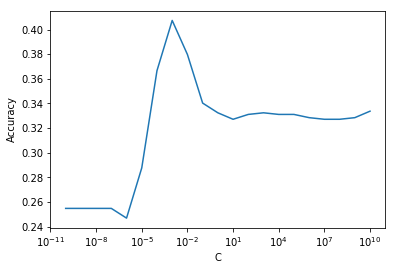

In [10]:
param_grid = {'C': np.logspace(-10, 10, 21)}
model = GridSearchCV(LogisticRegression(), param_grid, cv=4, scoring='accuracy', verbose=1)
model.fit(X_train, y_train)

plt.semilogx(model.param_grid['C'], model.cv_results_['mean_test_score'])
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

y_pred = model.predict(X_test)

## Results

----- Accuracy: 43.98 % -----
Filter: None (box size: 9 - only relevant for mean, gaussian and median filters)
n_clusters: 375


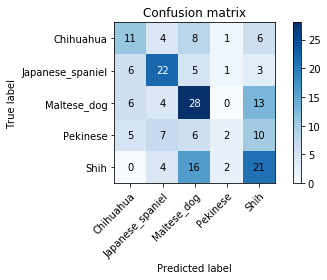

In [11]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()